In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
import glob
import cv2
import random
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from scipy.ndimage import label
from skimage.segmentation import watershed
torch.manual_seed(2022)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
np.random.seed(2022)
random.seed(2022)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
import numpy as np
import scipy
from scipy.optimize import linear_sum_assignment
from itertools import zip_longest
from itertools import islice
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:

class CustomDataset(Dataset):
    def __init__(self, dataset_dir, mode='train', transform=None):
        self.dataset_dir = dataset_dir
        self.mode = mode
        self.transform = transform

        self.images_dir = os.path.join(self.dataset_dir, self.mode, 'images')
        self.masks_dir = os.path.join(self.dataset_dir, self.mode, 'masks')

        self.image_filenames = os.listdir(self.images_dir)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, self.image_filenames[index])
        mask_path = os.path.join(self.masks_dir, self.image_filenames[index])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def __len__(self):
        return len(self.image_filenames)

def get_validation_augmentation():
    test_transform = [
        # transforms.RandomCrop((256, 256)),
        transforms.Resize((352, 352)),
        
        transforms.ToTensor(),
    ]
    return transforms.Compose(test_transform)

def to_tensor(x):
    return torch.from_numpy(x.transpose(2, 0, 1)).float()  # Add the 'return' statement


<h1>Load Dataset

In [3]:
dir_CVC = 'dataset/CVC-ClinicDB'
dir_Kvasir = 'dataset/Kvasir-SEG'
dir_BKAI = 'dataset/BKAI-IGH-NeoPolyp'

train_dataset_CVC = CustomDataset(
    dir_CVC,transform=get_validation_augmentation()
)
test_dataset_CVC = CustomDataset(
    dir_CVC, mode='test',transform=get_validation_augmentation()
)
train_dataset_Kvasir = CustomDataset(
    dir_Kvasir,transform=get_validation_augmentation()
)
test_dataset_Kvasir = CustomDataset(
    dir_Kvasir, mode='test',transform=get_validation_augmentation()
)
train_dataset_BKAI = CustomDataset(
    dir_BKAI,transform=get_validation_augmentation()
)
test_dataset_BKAI = CustomDataset(
    dir_BKAI, mode='test',transform=get_validation_augmentation()
)

print(f"Training CVC Size : {len(train_dataset_CVC)}")
print(f"Training Kvasir Size : {len(train_dataset_Kvasir)}")
print(f"Training BKAI Size : {len(train_dataset_BKAI)}")

print(f"Testing CVC Size : {len(test_dataset_CVC)}")
print(f"Testing Kvasir Size : {len(test_dataset_Kvasir)}")
print(f"Testing BKAI Size : {len(test_dataset_BKAI)}")


Training CVC Size : 544
Training Kvasir Size : 900
Training BKAI Size : 900
Testing CVC Size : 68
Testing Kvasir Size : 100
Testing BKAI Size : 100


In [4]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch
import torch.nn.functional as F

__all__ = ['Res2Net', 'res2net50_v1b', 'res2net101_v1b', 'res2net50_v1b_26w_4s']

model_urls = {
    'res2net50_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net50_v1b_26w_4s-3cf99910.pth',
    'res2net101_v1b_26w_4s': 'https://shanghuagao.oss-cn-beijing.aliyuncs.com/res2net/res2net101_v1b_26w_4s-0812c246.pth',
}


class Bottle2neck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, baseWidth=26, scale=4, stype='normal'):
        """ Constructor
        Args:
            inplanes: input channel dimensionality
            planes: output channel dimensionality
            stride: conv stride. Replaces pooling layer.
            downsample: None when stride = 1
            baseWidth: basic width of conv3x3
            scale: number of scale.
            type: 'normal': normal set. 'stage': first block of a new stage.
        """
        super(Bottle2neck, self).__init__()

        width = int(math.floor(planes * (baseWidth / 64.0)))
        self.conv1 = nn.Conv2d(inplanes, width * scale, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width * scale)

        if scale == 1:
            self.nums = 1
        else:
            self.nums = scale - 1
        if stype == 'stage':
            self.pool = nn.AvgPool2d(kernel_size=3, stride=stride, padding=1)
        convs = []
        bns = []
        for i in range(self.nums):
            convs.append(nn.Conv2d(width, width, kernel_size=3, stride=stride, padding=1, bias=False))
            bns.append(nn.BatchNorm2d(width))
        self.convs = nn.ModuleList(convs)
        self.bns = nn.ModuleList(bns)

        self.conv3 = nn.Conv2d(width * scale, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stype = stype
        self.scale = scale
        self.width = width

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        spx = torch.split(out, self.width, 1)
        for i in range(self.nums):
            if i == 0 or self.stype == 'stage':
                sp = spx[i]
            else:
                sp = sp + spx[i]
            sp = self.convs[i](sp)
            sp = self.relu(self.bns[i](sp))
            if i == 0:
                out = sp
            else:
                out = torch.cat((out, sp), 1)
        if self.scale != 1 and self.stype == 'normal':
            out = torch.cat((out, spx[self.nums]), 1)
        elif self.scale != 1 and self.stype == 'stage':
            out = torch.cat((out, self.pool(spx[self.nums])), 1)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Res2Net(nn.Module):

    def __init__(self, block, layers, baseWidth=26, scale=4, num_classes=1000):
        self.inplanes = 64
        super(Res2Net, self).__init__()
        self.baseWidth = baseWidth
        self.scale = scale
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.AvgPool2d(kernel_size=stride, stride=stride,
                             ceil_mode=True, count_include_pad=False),
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                            stype='stage', baseWidth=self.baseWidth, scale=self.scale))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, baseWidth=self.baseWidth, scale=self.scale))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def res2net50_v1b(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b lib.
    Res2Net-50 refers to the Res2Net-50_v1b_26w_4s.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model

def res2net50_v1b_26w_4s(pretrained=False, **kwargs):
    """Constructs a Res2Net-50_v1b_26w_4s lib.
    Args:
        pretrained (bool): If True, returns a lib pre-trained on ImageNet
    """
    model = Res2Net(Bottle2neck, [3, 4, 6, 3], baseWidth=26, scale=4, **kwargs)
    if pretrained:
        model_state = torch.load('model/res2net50_v1b_26w_4s-3cf99910.pth')
        model.load_state_dict(model_state)
        # lib.load_state_dict(model_zoo.load_url(model_urls['res2net50_v1b_26w_4s']))
    return model

<h1> PraNet

In [5]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class RFB_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RFB_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
        )
        self.branch1 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 3), padding=(0, 1)),
            BasicConv2d(out_channel, out_channel, kernel_size=(3, 1), padding=(1, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 5), padding=(0, 2)),
            BasicConv2d(out_channel, out_channel, kernel_size=(5, 1), padding=(2, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, kernel_size=(1, 7), padding=(0, 3)),
            BasicConv2d(out_channel, out_channel, kernel_size=(7, 1), padding=(3, 0)),
            BasicConv2d(out_channel, out_channel, 3, padding=7, dilation=7)
        )
        self.conv_cat = BasicConv2d(4*out_channel, out_channel, 3, padding=1)
        self.conv_res = BasicConv2d(in_channel, out_channel, 1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(torch.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        return x


class aggregation(nn.Module):
    # dense aggregation, it can be replaced by other aggregation previous, such as DSS, amulet, and so on.
    # used after MSF
    def __init__(self, channel):
        super(aggregation, self).__init__()
        self.relu = nn.ReLU(True)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_upsample1 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample2 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample3 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample4 = BasicConv2d(channel, channel, 3, padding=1)
        self.conv_upsample5 = BasicConv2d(2*channel, 2*channel, 3, padding=1)

        self.conv_concat2 = BasicConv2d(2*channel, 2*channel, 3, padding=1)
        self.conv_concat3 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv4 = BasicConv2d(3*channel, 3*channel, 3, padding=1)
        self.conv5 = nn.Conv2d(3*channel, 1, 1)

    def forward(self, x1, x2, x3):
        x1_1 = x1
        x2_1 = self.conv_upsample1(self.upsample(x1)) * x2
        x3_1 = self.conv_upsample2(self.upsample(self.upsample(x1))) \
               * self.conv_upsample3(self.upsample(x2)) * x3

        x2_2 = torch.cat((x2_1, self.conv_upsample4(self.upsample(x1_1))), 1)
        x2_2 = self.conv_concat2(x2_2)

        x3_2 = torch.cat((x3_1, self.conv_upsample5(self.upsample(x2_2))), 1)
        x3_2 = self.conv_concat3(x3_2)

        x = self.conv4(x3_2)
        x = self.conv5(x)

        return x


class PraNet(nn.Module):
    # res2net based encoder decoder
    def __init__(self, channel=32):
        super(PraNet, self).__init__()
        # ---- ResNet Backbone ----
        self.resnet = res2net50_v1b_26w_4s(pretrained=True)
        # ---- Receptive Field Block like module ----
        self.rfb2_1 = RFB_modified(512, channel)
        self.rfb3_1 = RFB_modified(1024, channel)
        self.rfb4_1 = RFB_modified(2048, channel)
        # ---- Partial Decoder ----
        self.agg1 = aggregation(channel)
        # ---- reverse attention branch 4 ----
        self.ra4_conv1 = BasicConv2d(2048, 256, kernel_size=1)
        self.ra4_conv2 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv3 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv4 = BasicConv2d(256, 256, kernel_size=5, padding=2)
        self.ra4_conv5 = BasicConv2d(256, 1, kernel_size=1)
        # ---- reverse attention branch 3 ----
        self.ra3_conv1 = BasicConv2d(1024, 64, kernel_size=1)
        self.ra3_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra3_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)
        # ---- reverse attention branch 2 ----
        self.ra2_conv1 = BasicConv2d(512, 64, kernel_size=1)
        self.ra2_conv2 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv3 = BasicConv2d(64, 64, kernel_size=3, padding=1)
        self.ra2_conv4 = BasicConv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)      # bs, 64, 88, 88
        # ---- low-level features ----
        x1 = self.resnet.layer1(x)      # bs, 256, 88, 88
        x2 = self.resnet.layer2(x1)     # bs, 512, 44, 44

        x3 = self.resnet.layer3(x2)     # bs, 1024, 22, 22
        x4 = self.resnet.layer4(x3)     # bs, 2048, 11, 11
        x2_rfb = self.rfb2_1(x2)        # channel -> 32
        x3_rfb = self.rfb3_1(x3)        # channel -> 32
        x4_rfb = self.rfb4_1(x4)        # channel -> 32

        ra5_feat = self.agg1(x4_rfb, x3_rfb, x2_rfb)
        lateral_map_5 = F.interpolate(ra5_feat, scale_factor=8, mode='bilinear')    # NOTES: Sup-1 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_4 ----
        crop_4 = F.interpolate(ra5_feat, scale_factor=0.25, mode='bilinear')
        x = -1*(torch.sigmoid(crop_4)) + 1
        x = x.expand(-1, 2048, -1, -1).mul(x4)
        x = self.ra4_conv1(x)
        x = F.relu(self.ra4_conv2(x))
        x = F.relu(self.ra4_conv3(x))
        x = F.relu(self.ra4_conv4(x))
        ra4_feat = self.ra4_conv5(x)
        x = ra4_feat + crop_4
        lateral_map_4 = F.interpolate(x, scale_factor=32, mode='bilinear')  # NOTES: Sup-2 (bs, 1, 11, 11) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_3 ----
        crop_3 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_3)) + 1
        x = x.expand(-1, 1024, -1, -1).mul(x3)
        x = self.ra3_conv1(x)
        x = F.relu(self.ra3_conv2(x))
        x = F.relu(self.ra3_conv3(x))
        ra3_feat = self.ra3_conv4(x)
        x = ra3_feat + crop_3
        lateral_map_3 = F.interpolate(x, scale_factor=16, mode='bilinear')  # NOTES: Sup-3 (bs, 1, 22, 22) -> (bs, 1, 352, 352)

        # ---- reverse attention branch_2 ----
        crop_2 = F.interpolate(x, scale_factor=2, mode='bilinear')
        x = -1*(torch.sigmoid(crop_2)) + 1
        x = x.expand(-1, 512, -1, -1).mul(x2)
        x = self.ra2_conv1(x)
        x = F.relu(self.ra2_conv2(x))
        x = F.relu(self.ra2_conv3(x))
        ra2_feat = self.ra2_conv4(x)
        x = ra2_feat + crop_2
        lateral_map_2 = F.interpolate(x, scale_factor=8, mode='bilinear')   # NOTES: Sup-4 (bs, 1, 44, 44) -> (bs, 1, 352, 352)

        return lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2

<h1>FDA

In [6]:
def low_freq_mutate_gau( amp_src, amp_trg, cova1=0, cova2=0):
    mean = [0, 0]
    covariance_matrix = [[cova1, 0], [0, cova2]]
    rv = multivariate_normal(mean, covariance_matrix)
    range_value = 1
    x, y = np.meshgrid(np.linspace(-range_value, range_value, 352), np.linspace(-range_value, range_value, 352))
    pos = np.dstack((x, y))
    pdf_values = rv.pdf(pos)
    amp_src = amp_src.cpu().numpy()
    amp_trg = amp_trg.cpu().numpy()
    pdf_values_normalized = (pdf_values - pdf_values.min()) / (pdf_values.max() - pdf_values.min())
    amp_src = amp_src * (1-pdf_values_normalized) + amp_trg * pdf_values_normalized
    return torch.from_numpy(amp_src).cuda()

@torch.no_grad()
def create_fda_gau(fr, to, cova1, cova2):
    # source : to, target : fr
    fft_src = torch.fft.fft2(to.clone()) 
    fft_trg = torch.fft.fft2(fr.clone())
    amp_src, pha_src = torch.fft.fftshift(torch.abs(fft_src)), torch.angle(fft_src)
    amp_trg, pha_trg = torch.fft.fftshift(torch.abs(fft_trg)), torch.angle(fft_trg)
    amp_src_ = low_freq_mutate_gau( amp_src.clone(), amp_trg.clone(), cova1=cova1, cova2=cova2)
    fft_src_ = torch.fft.ifftshift(amp_src_) * torch.exp( 1j * pha_src )
    src_in_trg = torch.fft.ifft2( fft_src_, dim=(-2, -1))
    src_in_trg = torch.real(src_in_trg)
    return src_in_trg

<h1>train

In [7]:

lr = 1e-4
batch_size = 4
epochs = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#for control randomness
torch.manual_seed(2022)
np.random.seed(2022)
random.seed(2022)

def custom_collate_fn(batch):
    images, masks = zip(*batch)
    images = torch.stack(images, dim=0)
    masks = torch.stack(masks, dim=0)
    return images, masks

from torch.utils.data import DataLoader
train_loader_CVC = DataLoader(train_dataset_CVC, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
#test_loader_CVC = DataLoader(test_dataset_CVC, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

train_loader_Kvasir = DataLoader(train_dataset_Kvasir, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader_Kvasir = DataLoader(test_dataset_Kvasir, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

train_loader_BKAI = DataLoader(train_dataset_BKAI, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader_BKAI = DataLoader(test_dataset_BKAI, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)


net = PraNet().to(device)

optimizer = torch.optim.Adam(net.parameters() , lr=lr, betas=(0.9, 0.999))
scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
train_losses = []
val_losses = []
start_epoch = 0


def entropy_loss(logits):
    probs = torch.nn.functional.softmax(logits, dim=1)
    log_probs = torch.nn.functional.log_softmax(logits, dim=1)
    entropy = -(probs * log_probs).sum(dim=1).mean()
    return entropy

def structure_loss(pred, mask): #pranet loss
    weit = 1 + 5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce = (weit*wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask)*weit).sum(dim=(2, 3))
    union = ((pred + mask)*weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1)/(union - inter+1)
    return (wbce + wiou).mean()


In [8]:
#학습이 누적되는 현상 발생
train_losses = []
train_fda_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
dice_arr = []
iou_arr = []
fn_loss = nn.BCEWithLogitsLoss().to(device)
scaler = torch.cuda.amp.GradScaler()

for epoch in range(epochs):
    net.train()
    loss_arr = []
    return_mask = []
    train_loss = 0.0
    trg_dice = 0.0
    fda_loss = 0.0
    fda_loss_arr = []
    tbar_CVC = tqdm(train_loader_CVC, total = len(train_loader_CVC), leave = True, position=0)
    tbar_Kvasir = tqdm(train_loader_Kvasir, total = len(train_loader_Kvasir), leave = True, position=1)

    for i, ((images_Kvasir, masks_Kvasir),(images_CVC, masks_CVC)) in enumerate( zip(tbar_Kvasir, islice( tbar_CVC, len(tbar_Kvasir) ) )):
        images_CVC = images_CVC.to(device)
        masks_CVC = masks_CVC.to(device)
        images_CVC = images_CVC.float()
        masks_CVC = masks_CVC.float()

        images_Kvasir = images_Kvasir.to(device)
        masks_Kvasir = masks_Kvasir.to(device)
        images_Kvasir = images_Kvasir.float()
        masks_Kvasir = masks_Kvasir.float()

        optimizer.zero_grad()
        lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2 = net(images_CVC)
        loss5 = structure_loss(lateral_map_5,masks_CVC)
        loss4 = structure_loss(lateral_map_4,masks_CVC)
        loss3 = structure_loss(lateral_map_3,masks_CVC)
        loss2 = structure_loss(lateral_map_2,masks_CVC)
        loss_src = loss2 + loss3 + loss4 + loss5 

        src_in_trg = create_fda_gau(images_Kvasir, images_CVC, 0.000045,0.000045)
        src_in_trg = src_in_trg.to(device)
        src_in_trg = src_in_trg.float()

        lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2 = net(src_in_trg)
        loss5 = structure_loss(lateral_map_5,masks_CVC)
        loss4 = structure_loss(lateral_map_4,masks_CVC)
        loss3 = structure_loss(lateral_map_3,masks_CVC)
        loss2 = structure_loss(lateral_map_2,masks_CVC)
        loss_trg = loss2 + loss3 + loss4 + loss5 

        lateral_map_5, lateral_map_4, lateral_map_3, lateral_map_2 = net(images_Kvasir)
        loss5 = entropy_loss(lateral_map_5)
        loss4 = entropy_loss(lateral_map_4)
        loss3 = entropy_loss(lateral_map_3)
        loss2 = entropy_loss(lateral_map_2)
        loss_trg_ent = loss2 + loss3 + loss4 + loss5 

        loss_sum = loss_src + loss_trg + loss_trg_ent
        loss_sum.backward()
        optimizer.step()

        train_loss += loss_sum.item()
        loss_arr += [loss_sum.item()]

        tbar_CVC.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, i * len(images_CVC), len(train_loader_CVC.dataset),
            100. * i / len(train_loader_CVC), (train_loss/(i+1) ) ))

    scheduler.step()  
    train_losses.append(np.mean(loss_arr))

torch.save(net.state_dict(), 'model_pranet_gfda_0.000045.pth.zip')

  0%|          | 0/136 [00:00<?, ?it/s]/home/kimseongmin/anaconda3/envs/torch1/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 12/225 [00:06<01:53,  1.88it/s]


KeyboardInterrupt: 

<h1> Metrics

In [ ]:
from scipy import ndimage
from scipy.ndimage import convolve, distance_transform_edt as bwdist


class cal_fm(object):
    # Fmeasure(maxFm,meanFm)---Frequency-tuned salient region detection(CVPR 2009)
    def __init__(self, num, thds=255):
        self.num = num
        self.thds = thds
        self.precision = np.zeros((self.num, self.thds))
        self.recall = np.zeros((self.num, self.thds))
        self.meanF = np.zeros((self.num,1))
        self.idx = 0

    def update(self, pred, gt):
        if gt.max() != 0:
            prediction, recall, Fmeasure_temp = self.cal(pred, gt)
            self.precision[self.idx, :] = prediction
            self.recall[self.idx, :] = recall
            self.meanF[self.idx, :] = Fmeasure_temp
        self.idx += 1

    def cal(self, pred, gt):
########################meanF##############################
        th = 2 * pred.mean()
        if th > 1:
            th = 1
        binary = np.zeros_like(pred)
        binary[pred >= th] = 1
        hard_gt = np.zeros_like(gt)
        hard_gt[gt > 0.5] = 1
        tp = (binary * hard_gt).sum()
        if tp == 0:
            meanF = 0
        else:
            pre = tp / binary.sum()
            rec = tp / hard_gt.sum()
            meanF = 1.3 * pre * rec / (0.3 * pre + rec)
########################maxF##############################
        pred = np.uint8(pred * 255)
        target = pred[gt > 0.5]
        nontarget = pred[gt <= 0.5]
        targetHist, _ = np.histogram(target, bins=range(256))
        nontargetHist, _ = np.histogram(nontarget, bins=range(256))
        targetHist = np.cumsum(np.flip(targetHist), axis=0)
        nontargetHist = np.cumsum(np.flip(nontargetHist), axis=0)
        precision = targetHist / (targetHist + nontargetHist + 1e-8)
        recall = targetHist / np.sum(gt)
        return precision, recall, meanF

    def show(self):
        assert self.num == self.idx
        precision = self.precision.mean(axis=0)
        recall = self.recall.mean(axis=0)
        fmeasure = 1.3 * precision * recall / (0.3 * precision + recall + 1e-8)
        fmeasure_avg = self.meanF.mean(axis=0)
        return fmeasure.max(),fmeasure_avg[0],precision,recall


class cal_mae(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, pred, gt):
        return np.mean(np.abs(pred - gt))

    def show(self):
        return np.mean(self.prediction)

class cal_dice(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        # smooth = 1
        smooth = 1e-5
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    def show(self):
        return np.mean(self.prediction)

class cal_ber(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        binary = np.zeros_like(y_pred)
        binary[y_pred >= 0.5] = 1
        hard_gt = np.zeros_like(y_true)
        hard_gt[y_true > 0.5] = 1
        tp = (binary * hard_gt).sum()
        tn = ((1-binary) * (1-hard_gt)).sum()
        Np = hard_gt.sum()
        Nn = (1-hard_gt).sum()
        ber = (1-(tp/Np+tn/Nn)/2)
        return ber

    def show(self):
        return np.mean(self.prediction)

class cal_acc(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, y_pred, y_true):
        binary = np.zeros_like(y_pred)
        binary[y_pred >= 0.5] = 1
        hard_gt = np.zeros_like(y_true)
        hard_gt[y_true > 0.5] = 1
        tp = (binary * hard_gt).sum()
        tn = ((1-binary) * (1-hard_gt)).sum()
        Np = hard_gt.sum()
        Nn = (1-hard_gt).sum()
        acc = ((tp+tn)/(Np+Nn))
        return acc

    def show(self):
        return np.mean(self.prediction)

class cal_iou(object):
    # mean absolute error
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    # def cal(self, input, target):
    #     classes = 1
    #     intersection = np.logical_and(target == classes, input == classes)
    #     # print(intersection.any())
    #     union = np.logical_or(target == classes, input == classes)
    #     return np.sum(intersection) / np.sum(union)

    def cal(self, input, target):
        smooth = 1e-5
        input = input > 0.5
        target_ = target > 0.5
        intersection = (input & target_).sum()
        union = (input | target_).sum()

        return (intersection + smooth) / (union + smooth)
    def show(self):
        return np.mean(self.prediction)

    # smooth = 1e-5
    #
    # if torch.is_tensor(output):
    #     output = torch.sigmoid(output).data.cpu().numpy()
    # if torch.is_tensor(target):
    #     target = target.data.cpu().numpy()
    # output_ = output > 0.5
    # target_ = target > 0.5
    # intersection = (output_ & target_).sum()
    # union = (output_ | target_).sum()

    # return (intersection + smooth) / (union + smooth)

class cal_sm(object):
    # Structure-measure: A new way to evaluate foreground maps (ICCV 2017)
    def __init__(self, alpha=0.5):
        self.prediction = []
        self.alpha = alpha

    def update(self, pred, gt):
        gt = gt > 0.5
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def show(self):
        return np.mean(self.prediction)

    def cal(self, pred, gt):
        y = np.mean(gt)
        if y == 0:
            score = 1 - np.mean(pred)
        elif y == 1:
            score = np.mean(pred)
        else:
            score = self.alpha * self.object(pred, gt) + (1 - self.alpha) * self.region(pred, gt)
        return score

    def object(self, pred, gt):
        fg = pred * gt
        bg = (1 - pred) * (1 - gt)

        u = np.mean(gt)
        return u * self.s_object(fg, gt) + (1 - u) * self.s_object(bg, np.logical_not(gt))

    def s_object(self, in1, in2):
        x = np.mean(in1[in2])
        sigma_x = np.std(in1[in2])
        return 2 * x / (pow(x, 2) + 1 + sigma_x + 1e-8)

    def region(self, pred, gt):
        [y, x] = ndimage.center_of_mass(gt)
        y = int(round(y)) + 1
        x = int(round(x)) + 1
        [gt1, gt2, gt3, gt4, w1, w2, w3, w4] = self.divideGT(gt, x, y)
        pred1, pred2, pred3, pred4 = self.dividePred(pred, x, y)

        score1 = self.ssim(pred1, gt1)
        score2 = self.ssim(pred2, gt2)
        score3 = self.ssim(pred3, gt3)
        score4 = self.ssim(pred4, gt4)

        return w1 * score1 + w2 * score2 + w3 * score3 + w4 * score4

    def divideGT(self, gt, x, y):
        h, w = gt.shape
        area = h * w
        LT = gt[0:y, 0:x]
        RT = gt[0:y, x:w]
        LB = gt[y:h, 0:x]
        RB = gt[y:h, x:w]

        w1 = x * y / area
        w2 = y * (w - x) / area
        w3 = (h - y) * x / area
        w4 = (h - y) * (w - x) / area

        return LT, RT, LB, RB, w1, w2, w3, w4

    def dividePred(self, pred, x, y):
        h, w = pred.shape
        LT = pred[0:y, 0:x]
        RT = pred[0:y, x:w]
        LB = pred[y:h, 0:x]
        RB = pred[y:h, x:w]

        return LT, RT, LB, RB

    def ssim(self, in1, in2):
        in2 = np.float32(in2)
        h, w = in1.shape
        N = h * w

        x = np.mean(in1)
        y = np.mean(in2)
        sigma_x = np.var(in1)
        sigma_y = np.var(in2)
        sigma_xy = np.sum((in1 - x) * (in2 - y)) / (N - 1)

        alpha = 4 * x * y * sigma_xy
        beta = (x * x + y * y) * (sigma_x + sigma_y)

        if alpha != 0:
            score = alpha / (beta + 1e-8)
        elif alpha == 0 and beta == 0:
            score = 1
        else:
            score = 0

        return score

class cal_em(object):
    #Enhanced-alignment Measure for Binary Foreground Map Evaluation (IJCAI 2018)
    def __init__(self):
        self.prediction = []

    def update(self, pred, gt):
        score = self.cal(pred, gt)
        self.prediction.append(score)

    def cal(self, pred, gt):
        th = 2 * pred.mean()
        if th > 1:
            th = 1
        FM = np.zeros(gt.shape)
        FM[pred >= th] = 1
        FM = np.array(FM,dtype=bool)
        GT = np.array(gt,dtype=bool)
        dFM = np.double(FM)
        if (sum(sum(np.double(GT)))==0):
            enhanced_matrix = 1.0-dFM
        elif (sum(sum(np.double(~GT)))==0):
            enhanced_matrix = dFM
        else:
            dGT = np.double(GT)
            align_matrix = self.AlignmentTerm(dFM, dGT)
            enhanced_matrix = self.EnhancedAlignmentTerm(align_matrix)
        [w, h] = np.shape(GT)
        score = sum(sum(enhanced_matrix))/ (w * h - 1 + 1e-8)
        return score
    def AlignmentTerm(self,dFM,dGT):
        mu_FM = np.mean(dFM)
        mu_GT = np.mean(dGT)
        align_FM = dFM - mu_FM
        align_GT = dGT - mu_GT
        align_Matrix = 2. * (align_GT * align_FM)/ (align_GT* align_GT + align_FM* align_FM + 1e-8)
        return align_Matrix
    def EnhancedAlignmentTerm(self,align_Matrix):
        enhanced = np.power(align_Matrix + 1,2) / 4
        return enhanced
    def show(self):
        return np.mean(self.prediction)
class cal_wfm(object):
    def __init__(self, beta=1):
        self.beta = beta
        self.eps = 1e-6
        self.scores_list = []

    def update(self, pred, gt):
        assert pred.ndim == gt.ndim and pred.shape == gt.shape
        assert pred.max() <= 1 and pred.min() >= 0
        assert gt.max() <= 1 and gt.min() >= 0

        gt = gt > 0.5
        if gt.max() == 0:
            score = 0
        else:
            score = self.cal(pred, gt)
        self.scores_list.append(score)

    def matlab_style_gauss2D(self, shape=(7, 7), sigma=5):
        """
        2D gaussian mask - should give the same result as MATLAB's
        fspecial('gaussian',[shape],[sigma])
        """
        m, n = [(ss - 1.) / 2. for ss in shape]
        y, x = np.ogrid[-m:m + 1, -n:n + 1]
        h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
        h[h < np.finfo(h.dtype).eps * h.max()] = 0
        sumh = h.sum()
        if sumh != 0:
            h /= sumh
        return h

    def cal(self, pred, gt):
        # [Dst,IDXT] = bwdist(dGT);
        Dst, Idxt = bwdist(gt == 0, return_indices=True)

        # %Pixel dependency
        # E = abs(FG-dGT);
        E = np.abs(pred - gt)
        # Et = E;
        # Et(~GT)=Et(IDXT(~GT)); %To deal correctly with the edges of the foreground region
        Et = np.copy(E)
        Et[gt == 0] = Et[Idxt[0][gt == 0], Idxt[1][gt == 0]]

        # K = fspecial('gaussian',7,5);
        # EA = imfilter(Et,K);
        # MIN_E_EA(GT & EA<E) = EA(GT & EA<E);
        K = self.matlab_style_gauss2D((7, 7), sigma=5)
        EA = convolve(Et, weights=K, mode='constant', cval=0)
        MIN_E_EA = np.where(gt & (EA < E), EA, E)

        # %Pixel importance
        # B = ones(size(GT));
        # B(~GT) = 2-1*exp(log(1-0.5)/5.*Dst(~GT));
        # Ew = MIN_E_EA.*B;
        B = np.where(gt == 0, 2 - np.exp(np.log(0.5) / 5 * Dst), np.ones_like(gt))
        Ew = MIN_E_EA * B

        # TPw = sum(dGT(:)) - sum(sum(Ew(GT)));
        # FPw = sum(sum(Ew(~GT)));
        TPw = np.sum(gt) - np.sum(Ew[gt == 1])
        FPw = np.sum(Ew[gt == 0])

        # R = 1- mean2(Ew(GT)); %Weighed Recall
        # P = TPw./(eps+TPw+FPw); %Weighted Precision
        R = 1 - np.mean(Ew[gt])
        P = TPw / (self.eps + TPw + FPw)

        # % Q = (1+Beta^2)*(R*P)./(eps+R+(Beta.*P));
        Q = (1 + self.beta) * R * P / (self.eps + R + self.beta * P)

        return Q

    def show(self):
        return np.mean(self.scores_list)

<h1>test

In [ ]:
print("test Kvasir")
test_loader_Kvasir = DataLoader(test_dataset_Kvasir, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
net.eval()
with torch.no_grad():   
    total_loss = 0
    iou_score = 0
    Dice_score = 0
    accuracy = 0
    recall = 0 
    precision = 0
    F1score = 0
    F2score = 0

    #output_directory1 = 'result_image/pred_0.00001'
    #output_directory2 = 'result_image/mask'
    idx = 0

    test_loader_Kvasir = DataLoader(test_dataset_Kvasir, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)
with torch.no_grad():   
    total_loss = 0
    iou_score = 0
    Dice_score = 0
    accuracy = 0
    recall = 0 
    precision = 0
    F1score = 0
    F2score = 0

    #output_directory1 = 'result_image/pred_0.00001'
    #output_directory2 = 'result_image/mask'
    idx = 0

    m_dice, m_iou, wfm, sm, em, mae = cal_dice(), cal_iou(), cal_wfm(), cal_sm(), cal_em(), cal_mae()
    tbar = tqdm(test_loader_Kvasir, total = len(test_loader_Kvasir), leave = True)
    for images, masks in tbar:    
        images = images.to(device)  # device는 GPU 장치를 가리키는 변수입니다.
        masks = masks.to(device)
        images = images.float() # convert to torch.float32
        masks = masks.float()
        res5, res4, rest3, output  = net(images)

        criterion = nn.BCEWithLogitsLoss()
        
        masks = torch.squeeze(masks, dim=0)
        pred2 = torch.squeeze(output, dim=0)
        masks = torch.squeeze(masks, dim=0)
        pred2 = torch.squeeze(pred2, dim=0)

        pred2 = torch.sigmoid(pred2)
        pred2 = (pred2 >= 0.5)
        pred2 = pred2.cpu()
        pred2 = pred2.detach().numpy()
        
        masks = masks.cpu()
        masks = masks.detach().numpy()

        gt = np.asarray(masks, np.float32)
        gt /= (gt.max() + 1e-8)
        gt[gt > 0.5] = 1
        gt[gt != 1] = 0

        res = pred2
        res = np.array(res)
        if res.max() == res.min():
            res = res/255
        else:
            res = (res ^ res.min()) / (res.max() ^ res.min())
        mae.update(res, gt)
        sm.update(res,gt)
        em.update(res, gt)
        wfm.update(res,gt)
        m_dice.update(res, gt)
        m_iou.update(res, gt)
        idx+=1
        
    MAE = mae.show()
    sm = sm.show()
    em = em.show()
    wfm = wfm.show()
    m_dice = m_dice.show()
    m_iou = m_iou.show()
    print('dataset: test_Kvasir M_dice: {:.4f} M_iou: {:.4f} wfm: {:.4f} Sm: {:.4f} Em: {:.4f} MAE: {:.4f}'
          .format(m_dice, m_iou,wfm,sm,em,MAE))

test Kvasir


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 20.67it/s]

dataset: test_Kvasir MAE: 0.0441 maxF: 0.8602 avgF: 0.8464 wfm: 0.8169 Sm: 0.8608 Em: 0.9112 M_dice: 0.8355 M_iou: 0.7596 Ber: 0.0893  Acc: 0.9559


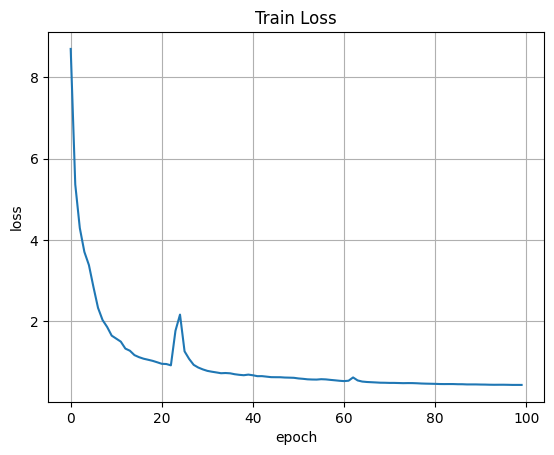

In [ ]:
import matplotlib.pyplot as plt

# 주어진 train_losses 배열
# x축은 인덱스, y축은 값으로 그래프 그리기
plt.plot(train_losses, linestyle='-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Train Loss')
plt.grid(True)

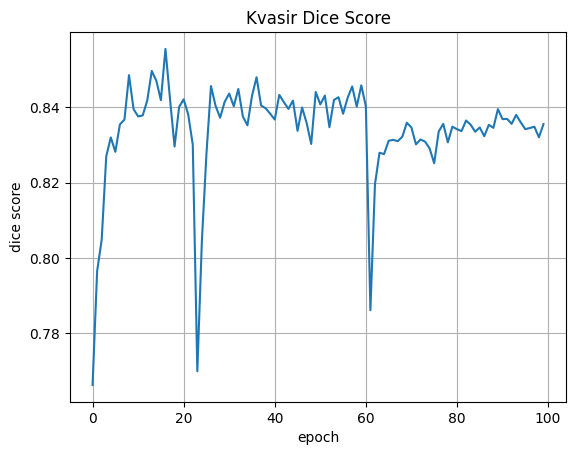

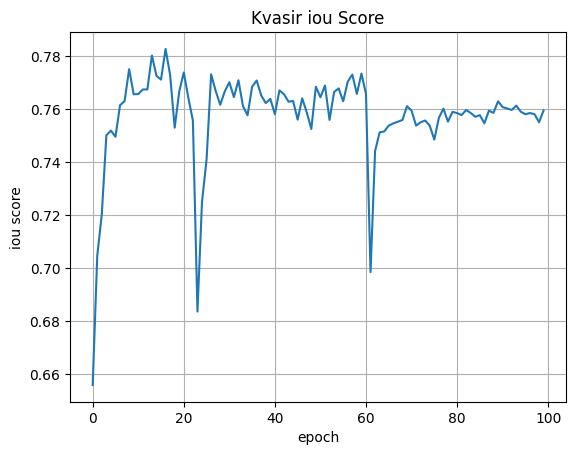

In [ ]:
# 주어진 train_losses 배열
# x축은 인덱스, y축은 값으로 그래프 그리기
plt.plot(dice_arr, linestyle='-')
plt.xlabel('epoch')
plt.ylabel('dice score')
plt.title('Kvasir Dice Score')
plt.grid(True)
plt.show()
plt.plot(iou_arr, linestyle='-')
plt.xlabel('epoch')
plt.ylabel('iou score')
plt.title('Kvasir iou Score')
plt.grid(True)
plt.show()